In [2]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import solve_bvp
from scipy.optimize import root

# Problem Set-Up:


The most basic scenario is the following:
$$ J[\tau] = \int_{0}^{t_f} (n(t)^2 + \alpha \tau(t)^2 + \tau(t)^{10}) \, dt$$
$$\dot{n}(t) = 1 - \tau(t) - \beta n(t) $$
$$n(0) = n_0$$

- I added the $\tau^{10}$ in order to heavily penalize values of |$\tau$| > 1. This is a substitute for the constraint  $ \tau \leq 1$
- I think $\tau < 0$ isn't a huge deal. We could interpret that as a subsidy (government gives the company money)
- The state evolution equations are the same, but now the optimal u is given by:
$$ -p(t) - 2\alpha \tau(t) -10\tau(t)^9 = 0$$
- This can be solved explicitly using scipy.optimize.root, but it does have some convergence issues. Nevertheless, the results look okay.
- For larger values of alpha and beta, there are some stability problems, but for smaller values, it does okay.
- We have the option of constraining $n(t_f)$ or $p(t_f)$.
- For some choices of parameters, $\tau(t) > 1$ for some $t$. I don't think that's too big of a deal because there are some choices of parameters that are infeasible. For example, if we constrained $n(t_f)$ and the pollution starts really high and $\beta$ is really low, it will be impossible to tax the company enough to get the pollution levels down to 0. The only way to get that to work would be to have $\tau$ large.

Andrew, I made some tiny edits to this general class here. Specifically, I changed u_func to only depend on x (I removed the t). I did this to get scipy.optimize.root to work, but I realize that if u is not autonomous that will change things. That is a problem we can tackle down the road

## General class
Here we make a class that accepts a function that represents the differential equation in terms of the state and costate.
We also pass in a value for the optimal control.


In [18]:
class Control_Solver_Plotter:
    def __init__(self):
        self.t = None
        self.x = None
        self.u = None
        self.ode = None
        self.u_func = None
        self.bc = None

    def define_evolution(self,ode,bc):
        self.ode = ode
        self.bc = bc
        return self

    def define_control_function(self,u_func):
        self.u_func = u_func
        return self

    def solve_problem(self, t0, tf=None, n_points=100, x_guess=None):
        param = False
        if tf is None:
            tf = 1
            param = True
        
        self.t = np.linspace(t0, tf, n_points + 1)
        
        # Initialize x_guess if not provided
        if x_guess is None:
            x_guess = np.ones((2,n_points + 1))
        
        # Solve the boundary value problem
        if param:
            param_guess = np.array([1])  # Example parameter guess
            sol = solve_bvp(self.ode, self.bc, self.t, x_guess, param_guess)
        else:
            sol = solve_bvp(self.ode, self.bc, self.t, x_guess)
        
        # Assign solution to class attributes
        self.t = sol.x
        self.x = sol.y
        self.u = self.u_func(sol.y)
        
        return self

    def plot_solution(self,color, subplot = None, ax0=None, ax1=None, labels = None):

        
        ax0.plot(self.t,self.x[0],color,label = f'$\\alpha$ = {labels[0]} and $\\beta$={labels[1]}')
        ax1.plot(self.t,self.u,color,label = f'$\\alpha$ = {labels[0]} and $\\beta$={labels[1]}')
        ax0.set_title('Pollution')
        ax0.legend()
        ax1.set_title('Tax')
        ax1.legend()

In [19]:
def PlotSimplestProblem(alpha, beta, n0, nf, t0, tf, color, ax0=None, ax1=None):
    a, b = 1, 2

    def u_func(x):
        def implicitFormula(u):
            return -a*x[1] - 2*alpha*u - 10*(u**9) # You could make the coefficient on the second u arbitrarily large
        return root(implicitFormula, x0=np.ones_like(x[1])*0.1).x # This has some convergence issues
    

    def ode(t,x):
        return np.array([
            .5*(b-a*u_func(x)) - beta*x[0],
            2*x[0] + beta*x[1]
            ])
    def bc(ya,yb):
        return np.array([ya[0]-n0, yb[1]])

    plotter = Control_Solver_Plotter().define_control_function(u_func).define_evolution(ode,bc)
    plotter.solve_problem(t0,tf)
    plotter.plot_solution(ax0=ax0, ax1=ax1, labels = [alpha, beta], color=color)

There is still quite a bit of variation in what the graph looks like, depending on the parameters you put in. And sometimes there are some stability problems, but it's looking a little better.

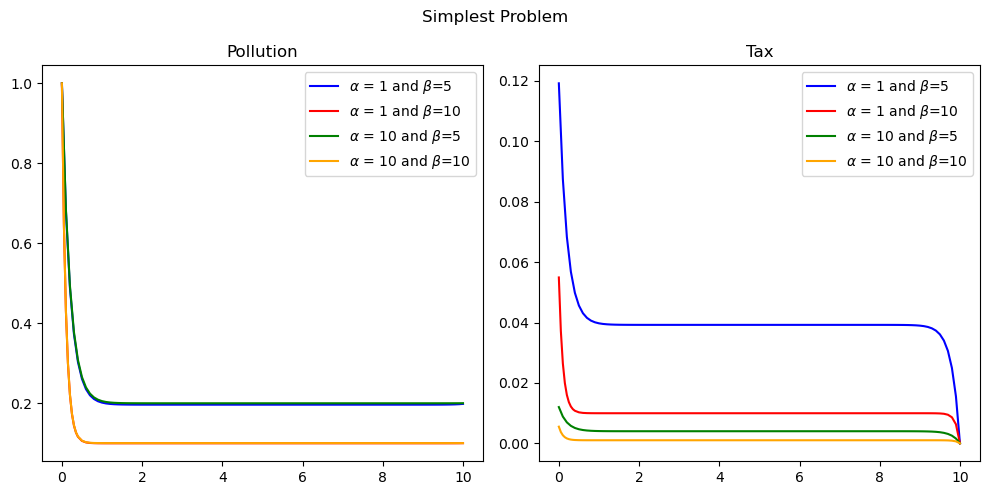

In [23]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

colors = ['Blue', 'Red', 'Green', 'Orange', 'Magenta', 'Yellow', 'Black', 'White', 'Gray', 'Cyan']

i = 0
for alph in [1, 10]:
    for beta in [5, 10]:
        PlotSimplestProblem(alpha=alph, beta=beta, n0=1, nf=0.5, t0=0, tf=10, ax0=axs.ravel()[i%2], ax1=axs.ravel()[(i+1)%2], color=colors[int(i/2)])
        i += 2

plt.suptitle("Simplest Problem")
plt.tight_layout()
plt.show()

Questions:
- What choices of parameters should we use?
- Should we make the y-axis on all of the graphs the same? It might make the graphs easier to compare.
- The endpoint conditions really change things quite a bit: Is there a way we can do infinite time-horizon? My guess is it would just approach a steady-state solution, but it would be nice to confirm that.